<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-science-bookcamp/case-study-2--online-ad-clicks/05_case_study_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Case study 2 solution

We’ve been asked to analyze the online ad-click data collected by our buddy Fred.
His advertising data table monitors ad clicks across 30 different colors. Our aim is
to discover an ad color that generates significantly more clicks than blue.

We will do so by following these steps:
* Load and clean our advertising data using Pandas.
* Run a permutation test between blue and the other recorded colors.
* Check the computed p-values for statistical significance using a properly
determined significance level.

##Setup

In [1]:
from collections import defaultdict
import itertools

import numpy as np
import pandas as pd
from scipy import stats
import math

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!wget https://github.com/rahiakela/data-science-research-and-practice/raw/main/data-science-bookcamp/case-study-2--online-ad-clicks/colored_ad_click_table.csv

In [3]:
# Penalizing centers using the squared distance from the minimum
def squared_distance(value1, value2):
  return (value1 - value2) ** 2

In [4]:
# Penalizing centers using the total sum of squared distances
def sum_of_squared_distances(value, measurements):
  return sum(squared_distance(value, m) for m in measurements)

In [5]:
# Computing California’s sum of squares
def sum_of_squares(data):
  mean = np.mean(data)
  return sum(squared_distance(value, mean) for value in data)

In [6]:
# Computing the variance from mean squared distance
def variance(data):
  mean = np.mean(data)
  return np.mean([squared_distance(value, mean) for value in data])

In [7]:
# Computing the weighted variance using np.average
def weighted_variance(data, weights):
  mean = np.average(data, weights=weights)
  squared_distances = [squared_distance(value, mean) for value in data]
  return np.average(squared_distances, weights=weights)

assert weighted_variance([75, 77], [9, 1]) == np.var(9 * [75] + [77])

##Loading dataset

Let’s begin by loading our ad-click table into Pandas.

In [8]:
# Loading the ad-click table into Pandas
df = pd.read_csv("colored_ad_click_table.csv")
print(f"Table contains {df.shape[0]} rows and {df.shape[1]} columns")

Table contains 30 rows and 41 columns


In [9]:
# Checking the column names
print(df.columns)

Index(['Color', 'Click Count: Day 1', 'View Count: Day 1',
       'Click Count: Day 2', 'View Count: Day 2', 'Click Count: Day 3',
       'View Count: Day 3', 'Click Count: Day 4', 'View Count: Day 4',
       'Click Count: Day 5', 'View Count: Day 5', 'Click Count: Day 6',
       'View Count: Day 6', 'Click Count: Day 7', 'View Count: Day 7',
       'Click Count: Day 8', 'View Count: Day 8', 'Click Count: Day 9',
       'View Count: Day 9', 'Click Count: Day 10', 'View Count: Day 10',
       'Click Count: Day 11', 'View Count: Day 11', 'Click Count: Day 12',
       'View Count: Day 12', 'Click Count: Day 13', 'View Count: Day 13',
       'Click Count: Day 14', 'View Count: Day 14', 'Click Count: Day 15',
       'View Count: Day 15', 'Click Count: Day 16', 'View Count: Day 16',
       'Click Count: Day 17', 'View Count: Day 17', 'Click Count: Day 18',
       'View Count: Day 18', 'Click Count: Day 19', 'View Count: Day 19',
       'Click Count: Day 20', 'View Count: Day 20'],
      dtyp

In [10]:
# Checking the color names
print(df.Color.values)

['Pink' 'Gray' 'Sapphire' 'Purple' 'Coral' 'Olive' 'Navy' 'Maroon' 'Teal'
 'Cyan' 'Orange' 'Black' 'Tan' 'Red' 'Blue' 'Brown' 'Turquoise' 'Indigo'
 'Gold' 'Jade' 'Ultramarine' 'Yellow' 'Virdian' 'Violet' 'Green'
 'Aquamarine' 'Magenta' 'Silver' 'Bronze' 'Lime']


In [11]:
# Checking for blue
assert "Blue" in df.Color.values

In [12]:
# Summarizing day 1 of the experiment
selected_columns = ["Color", "Click Count: Day 1", "View Count: Day 1"]
print(df[selected_columns].describe())

       Click Count: Day 1  View Count: Day 1
count           30.000000               30.0
mean            23.533333              100.0
std              7.454382                0.0
min             12.000000              100.0
25%             19.250000              100.0
50%             24.000000              100.0
75%             26.750000              100.0
max             49.000000              100.0


In [13]:
# Summarizing day 2 of the experiment
selected_columns = ["Color", "Click Count: Day 2", "View Count: Day 2"]
print(df[selected_columns].describe())

       Click Count: Day 2  View Count: Day 2
count           30.000000               30.0
mean            24.433333              100.0
std              5.864465                0.0
min             15.000000              100.0
25%             21.000000              100.0
50%             24.000000              100.0
75%             28.000000              100.0
max             41.000000              100.0


In [14]:
# Confirming equivalent daily views
view_columns = [col for col in df.columns if "View" in col]
assert np.all(df[view_columns].values == 100)

In [15]:
# Deleting view counts from the table
df.drop(columns=view_columns, inplace=True)
print(df.columns)

Index(['Color', 'Click Count: Day 1', 'Click Count: Day 2',
       'Click Count: Day 3', 'Click Count: Day 4', 'Click Count: Day 5',
       'Click Count: Day 6', 'Click Count: Day 7', 'Click Count: Day 8',
       'Click Count: Day 9', 'Click Count: Day 10', 'Click Count: Day 11',
       'Click Count: Day 12', 'Click Count: Day 13', 'Click Count: Day 14',
       'Click Count: Day 15', 'Click Count: Day 16', 'Click Count: Day 17',
       'Click Count: Day 18', 'Click Count: Day 19', 'Click Count: Day 20'],
      dtype='object')


In [16]:
# Summarizing daily blue-click statistics
df.set_index("Color", inplace=True)
print(df.T.Blue.describe())

count    20.000000
mean     28.350000
std       5.499043
min      18.000000
25%      25.750000
50%      27.500000
75%      30.250000
max      42.000000
Name: Blue, dtype: float64


##Computing p-values from differences in means

Let’s start by filtering the data.

In [17]:
# Creating a no-blue table
df_not_blue = df.T.drop(columns="Blue")
print(df_not_blue.head(2))

Color               Pink  Gray  Sapphire  Purple  Coral  Olive  Navy  Maroon  \
Click Count: Day 1    21    27        30      26     26     26    38      21   
Click Count: Day 2    20    27        32      21     24     19    29      29   

Color               Teal  Cyan  ...  Ultramarine  Yellow  Virdian  Violet  \
Click Count: Day 1    25    24  ...           49      14       27      15   
Click Count: Day 2    25    22  ...           41      24       23      22   

Color               Green  Aquamarine  Magenta  Silver  Bronze  Lime  
Click Count: Day 1     14          24       18      26      19    20  
Click Count: Day 2     25          28       21      24      19    19  

[2 rows x 29 columns]


In [18]:
# Defining a permutation test function
def permutation_test(data_array_a, data_array_b):
  data_mean_a = data_array_a.mean()
  data_mean_b = data_array_b.mean()
  # Observed difference between sample means
  extreme_mean_diff = abs(data_mean_a - data_mean_b)
  total_data = np.hstack([data_array_a, data_array_b])

  number_extreme_values = 0.0
  for _ in range(30000):
    np.random.shuffle(total_data)
    sample_a = total_data[: data_array_a.size]
    sample_b = total_data[data_array_a.size: ]
    # The difference between resampled means is extremely large
    if abs(sample_a.mean() - sample_b.mean()) >= number_extreme_values:
      number_extreme_values += 1

  p_value = number_extreme_values / 30000
  return p_value

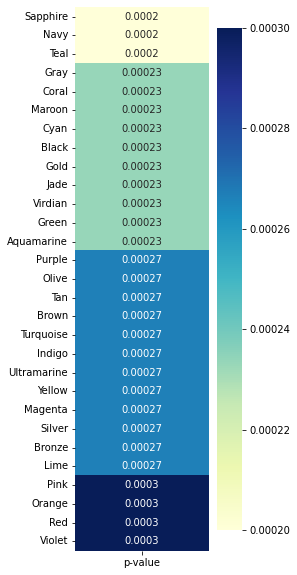

In [19]:
# Running a permutation test across colors
np.random.seed(0)

blue_clicks = df.T.Blue.values
color_to_p_value = {}

for color, color_clicks in df_not_blue.items():
  p_value = permutation_test(blue_clicks, color_clicks)
  color_to_p_value[color] = p_value

# sort a dictionary and return two lists
sorted_colors, sorted_p_values = zip(*sorted(color_to_p_value.items(), key=lambda x: x[1]))

plt.figure(figsize=(3, 10))
sns.heatmap([[p_value] for p_value in sorted_p_values],
            cmap="YlGnBu", 
            annot=True,
            xticklabels=["p-value"],
            yticklabels=sorted_colors)
plt.show()

In [20]:
# Finding the mean click rate of black
mean_black = df_not_blue.Black.mean()
print(f"Mean click-rate of black is {mean_black}")

Mean click-rate of black is 21.6


In [21]:
# Filtering colors with inferior click rates
remaining_colors = df[df.T.mean().values > blue_clicks.mean()].index
size = remaining_colors.size  
print(f"{size} colors have on average more clicks than Blue.")
print("These colors are:")
print(remaining_colors.values)

5 colors have on average more clicks than Blue.
These colors are:
['Sapphire' 'Navy' 'Teal' 'Ultramarine' 'Aquamarine']


In [22]:
# Printing the five remaining colors
for color, p_value in sorted(color_to_p_value.items(), key=lambda x: x[1]):
  if color in remaining_colors:
    mean = df_not_blue[color].mean()
    print(f"{size} has a p-value of {p_value} and a mean of {mean}")

5 has a p-value of 0.0002 and a mean of 28.9
5 has a p-value of 0.0002 and a mean of 29.3
5 has a p-value of 0.0002 and a mean of 28.45
5 has a p-value of 0.00023333333333333333 and a mean of 29.2
5 has a p-value of 0.0002666666666666667 and a mean of 34.2


##Determining statistical significance

In [23]:
# Applying the Bonferroni correction
significance_level = 0.05 / 29

print(f"Adjusted significance level is {significance_level}")
if color_to_p_value["Ultramarine"] <= significance_level:
  print("Our p-value is statistically significant")
else:
  print("Our p-value is not statistically significant")

Adjusted significance level is 0.001724137931034483
Our p-value is statistically significant


In [24]:
# Exploring a hypothetical significance level
hypothetical_sig_level = 0.05 / 5

print(f"Hypothetical significance level is {hypothetical_sig_level}")
if color_to_p_value["Ultramarine"] <= hypothetical_sig_level:
  print("Our hypothetical p-value would have been statistically significant")
else:
  print("Our hypothetical p-value would not have been statistically significant")

Hypothetical significance level is 0.01
Our hypothetical p-value would have been statistically significant


More data isn’t necessarily better: sometimes more data leads to
more uncertainty.